In [ ]:
%pip install pyarrow
%pip install deephyper["nas"]
%pip install Pillow

In [5]:
import numpy as np
type(np.asarray(['1']))

numpy.ndarray

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import collections
import pathlib
import json

from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

from deephyper.problem import NaProblem
from deephyper.nas.preprocessing import minmaxstdscaler

import multiprocessing

from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback
from deephyper.nas.run import run_base_trainer

from deephyper.search.nas import AgEBO

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model 

tf.__version__

'2.11.0'

In [5]:
DATA_LENGTH = 94477
BATCH_SIZE = 64 
GLOBAL_BATCH_SIZE = BATCH_SIZE
AUTO = tf.data.AUTOTUNE

In [5]:

##### Read TFRecord file
def _parse_tfr_element(element):
    parse_dic = {
    'b_feature': tf.io.FixedLenFeature([], tf.string), # Note that it is tf.string, not tf.float32
    'b_label': tf.io.FixedLenFeature([], tf.string),
    }
    example_message = tf.io.parse_single_example(element, parse_dic)

    b_feature = example_message['b_feature'] # get byte string
    b_label = example_message['b_label']
    
    feature = tf.io.parse_tensor(b_feature, out_type=tf.float32) # restore 2D array from byte string
    label = tf.io.parse_tensor(b_label, out_type=tf.int32)
    return (feature, label)

filenames = [f'/kaggle/input/tfrecords-sequences-for-asl/data{i}.tfrecords' for i in range(20)]
train_dataset = tf.data.TFRecordDataset(filenames) 
train_dataset = train_dataset.map(_parse_tfr_element, num_parallel_calls=AUTO).prefetch(AUTO)

In [7]:
def load_data():
    feature = []
    label = []
    for i,j in train_dataset.as_numpy_iterator():
        feature.append(i)
        label.append(j)

    feature_train, feature_test = np.split(feature, [int(len(feature)*0.9)])
    label_train, label_test = np.split(label, [int(len(label)*0.9)])
    return (feature_train, label_train), (feature_test, label_test)

In [13]:
import collections

import tensorflow as tf

from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

LSTM = operation(tf.keras.layers.LSTM)
Dense = operation(tf.keras.layers.Dense)
Concatenate = operation(tf.keras.layers.Concatenate)
Dropout = operation(tf.keras.layers.Dropout)
TimeDistributed = operation(tf.keras.layers.TimeDistributed)
Bidirectional = operation(tf.keras.layers.Bidirectional)
Flatten = operation(tf.keras.layers.Flatten)

class LSTMLP_Factory(KSearchSpace):

    def __init__(self, input_shape, output_shape, seed=None, num_layers=3, mode="classification"):
        super().__init__(input_shape, output_shape, seed=seed)

        self.num_layers = num_layers
        assert mode in ["regression", "classification"]
        self.mode = mode

    def build(self):


        # Three input tensors are automatically created based on the `input_shape`
        source = prev_input = self.input_nodes[0]

        # Creates a Queue to store outputs of the 3 previously created  layers
        # to create potential residual connections
        anchor_points  = collections.deque([source], maxlen=3)
        
        for _ in range(self.num_layers):
            lstm = VariableNode()
            self.add_bidir_td_lstm_to_(lstm)
            self.connect(prev_input, lstm)
            x = lstm
            
            drop_or_dense = VariableNode()
            self.add_dropout_to_(drop_or_dense)
            self.add_dense_to_(drop_or_dense)
            self.connect(x, drop_or_dense)
            x = drop_or_dense
            
            add = ConstantNode()
            add.set_op(AddByProjecting(self, [x], activation="relu"))

            for anchor in anchor_points :
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, add)

            prev_input = add
            anchor_points.append(prev_input)

        if self.mode == "regression":
            output_node = ConstantNode(Dense(self.output_shape[0]))
            self.connect(prev_input, output_node)
        else:
            
            
            flattener = ConstantNode()
            flattener.set_op(Flatten())
            self.connect(prev_input,flattener)
            
            
            output_net0 = VariableNode()
            self.add_dense_to_(output_net0)
            self.connect(flattener, output_net0)
            
            output_net1 = VariableNode()
            self.add_dense_to_(output_net1)
            self.connect(output_net0, output_net1)
            
            output_net2 = VariableNode()
            self.add_dense_to_(output_net2)
            self.connect(output_net1, output_net2)

            
            output_net3 = VariableNode()
            self.add_dense_to_(output_net3)
            self.connect(output_net2, output_net3)
            
            output_net4 = VariableNode()
            self.add_dense_to_(output_net4)
            self.connect(output_net3, output_net4)
            
            # --------------------------vvvvvvvvv ------------------------------------------------
            
            merge_1 = ConstantNode()
            merge_1.set_op(AddByProjecting(self, [output_net4], activation="relu"))

            
            for anchor in collections.deque([output_net0,output_net1,output_net2,output_net3,output_net4]):
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, anchor))
                self.connect(skipco, merge_1)
            
            # ----------------------------^^^^^^^^-----------------------------------------------
                
            output_node = ConstantNode(Dense(self.output_shape[0], activation="softmax"))
            self.connect(merge_1, output_node)

        return self
    
    def add_bidir_td_lstm_to_(self,node):
        node.add_op(Identity())
        for unit in range(16, 128, 16):
            node.add_op(TimeDistributed(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=unit,return_sequences=True))))
    
    def add_lstm_to_(self,node):
        node.add_op(Identity())
        for unit in range(16, 128, 16):
            node.add_op(tf.keras.layers.LSTM(units=unit,return_sequences=True))
            node.add_op(tf.keras.layers.LSTM(units=unit,return_sequences=False))
            
    def add_Bilstm_to_(self,node):
        node.add_op(Identity())
        for unit in range(16, 128, 16):
            node.add_op(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=unit,return_sequences=True)))
            node.add_op(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=unit,return_sequences=False)))

    
    def add_dense_to_(self, node):
        node.add_op(Identity())  # we do not want to create a layer in this case

        activations = [
            tf.keras.activations.linear,
            tf.keras.activations.relu,
            tf.keras.activations.tanh,
            tf.keras.activations.sigmoid,
        ]
        for units in range(16, 97, 16):
            for activation in activations:
                node.add_op(Dense(units=units, activation=activation))
                
    def add_dropout_to_(self, node):
        a, b = 1e-3, 0.4
        node.add_op(Identity())
        dropout_range = np.exp(np.linspace(np.log(a), np.log(b), 10))  #! NAS
        for rate in dropout_range:
            node.add_op(Dropout(rate))

[(0, 7), (0, 35), (0, 1), (0, 7), (0, 35), (0, 1), (0, 1), (0, 7), (0, 35), (0, 1), (0, 1), (0, 1), (0, 24), (0, 24), (0, 24), (0, 24), (0, 24), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]
<class 'keras.engine.functional.Functional'>


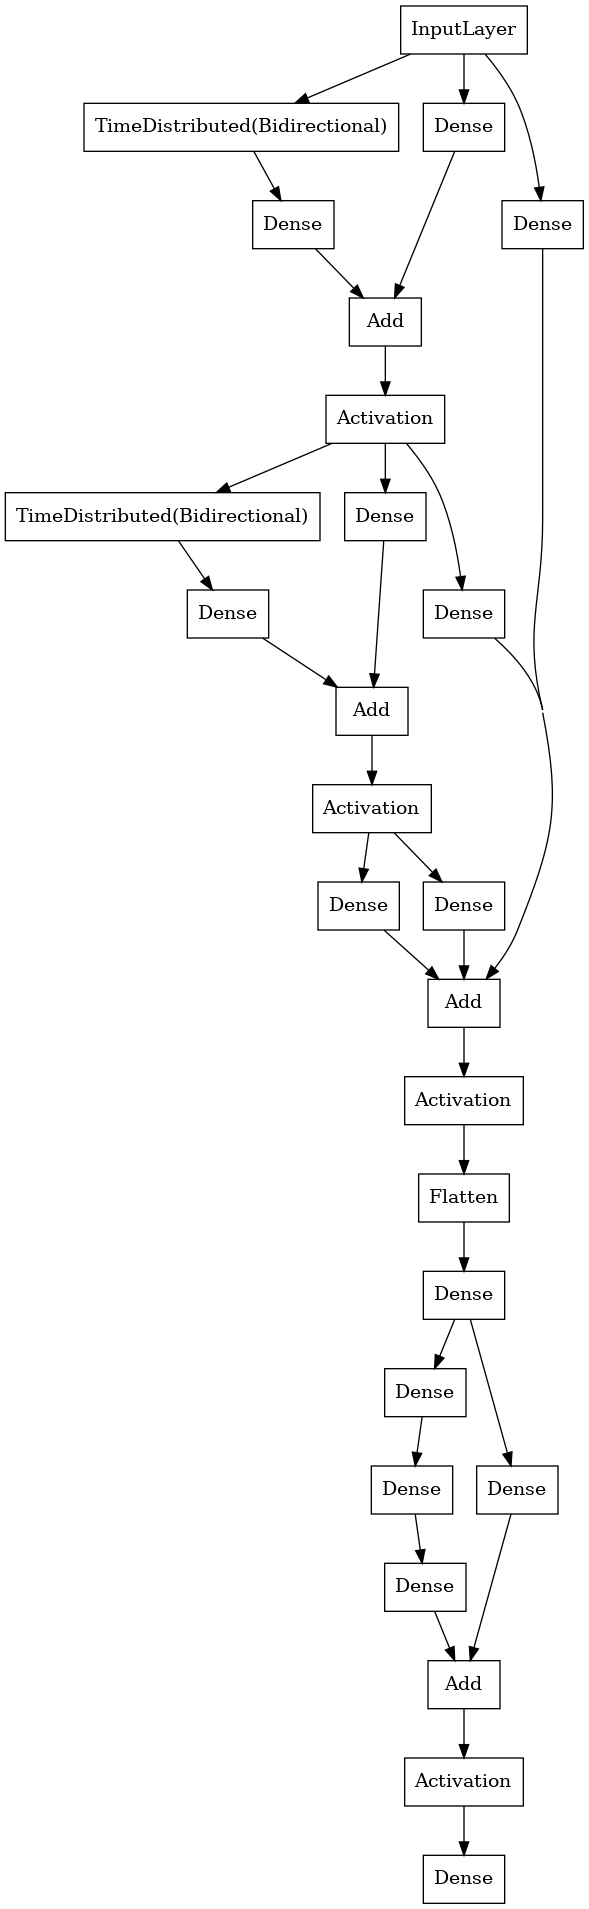

In [9]:
shapes = dict(input_shape=[(50,115,3)], output_shape=(250,))
space = LSTMLP_Factory(**shapes,num_layers=3).build()
print(space.choices())
model = space.sample()
print(type(model))
plot_model(model, show_shapes=False, show_layer_names=False)

In [10]:
problem = NaProblem()

problem.load_data(load_data)

problem.search_space(LSTMLP_Factory)

problem.hyperparameters(
    batch_size=32,
    learning_rate=1e-15,
    optimizer="adam",
    epsilon=1e-7,
    num_epochs=20,
    callbacks=dict(
        EarlyStopping=dict( 
            monitor='val_accuracy', mode='max', min_delta=0.1, patience=30
        )
    )
)

problem.loss('sparse_categorical_crossentropy')
problem.metrics(['accuracy'])
problem.objective('val_acc__max')
problem

Problem is:
    - search space   : __main__.LSTMLP_Factory
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: 32
        * learning_rate: 1e-15
        * optimizer: adam
        * epsilon: 1e-07
        * num_epochs: 20
        * callbacks: {'EarlyStopping': {'monitor': 'val_accuracy', 'mode': 'max', 'min_delta': 0.1, 'patience': 30}}
    - loss           : sparse_categorical_crossentropy
    - metrics        : 
        * accuracy
    - objective      : val_acc__max

In [11]:
multiprocessing.cpu_count()

4

In [13]:
evaluator = Evaluator.create(
    run_base_trainer,
    method="process",
    method_kwargs={
        "num_workers": 10,
        "callbacks":[TqdmCallback()]
    }
    
)
evaluator.num_workers

/opt/conda/lib/python3.7/site-packages/deephyper/evaluator/_evaluator.py:127: UserWarning: Applying nest-asyncio patch for IPython Shell!
  "Applying nest-asyncio patch for IPython Shell!", category=UserWarning


10

In [1]:
from deephyper.search.nas import AgEBO,RegularizedEvolution

search = RegularizedEvolution(problem,evaluator)

ModuleNotFoundError: No module named 'deephyper'

In [ ]:
search.search(1)

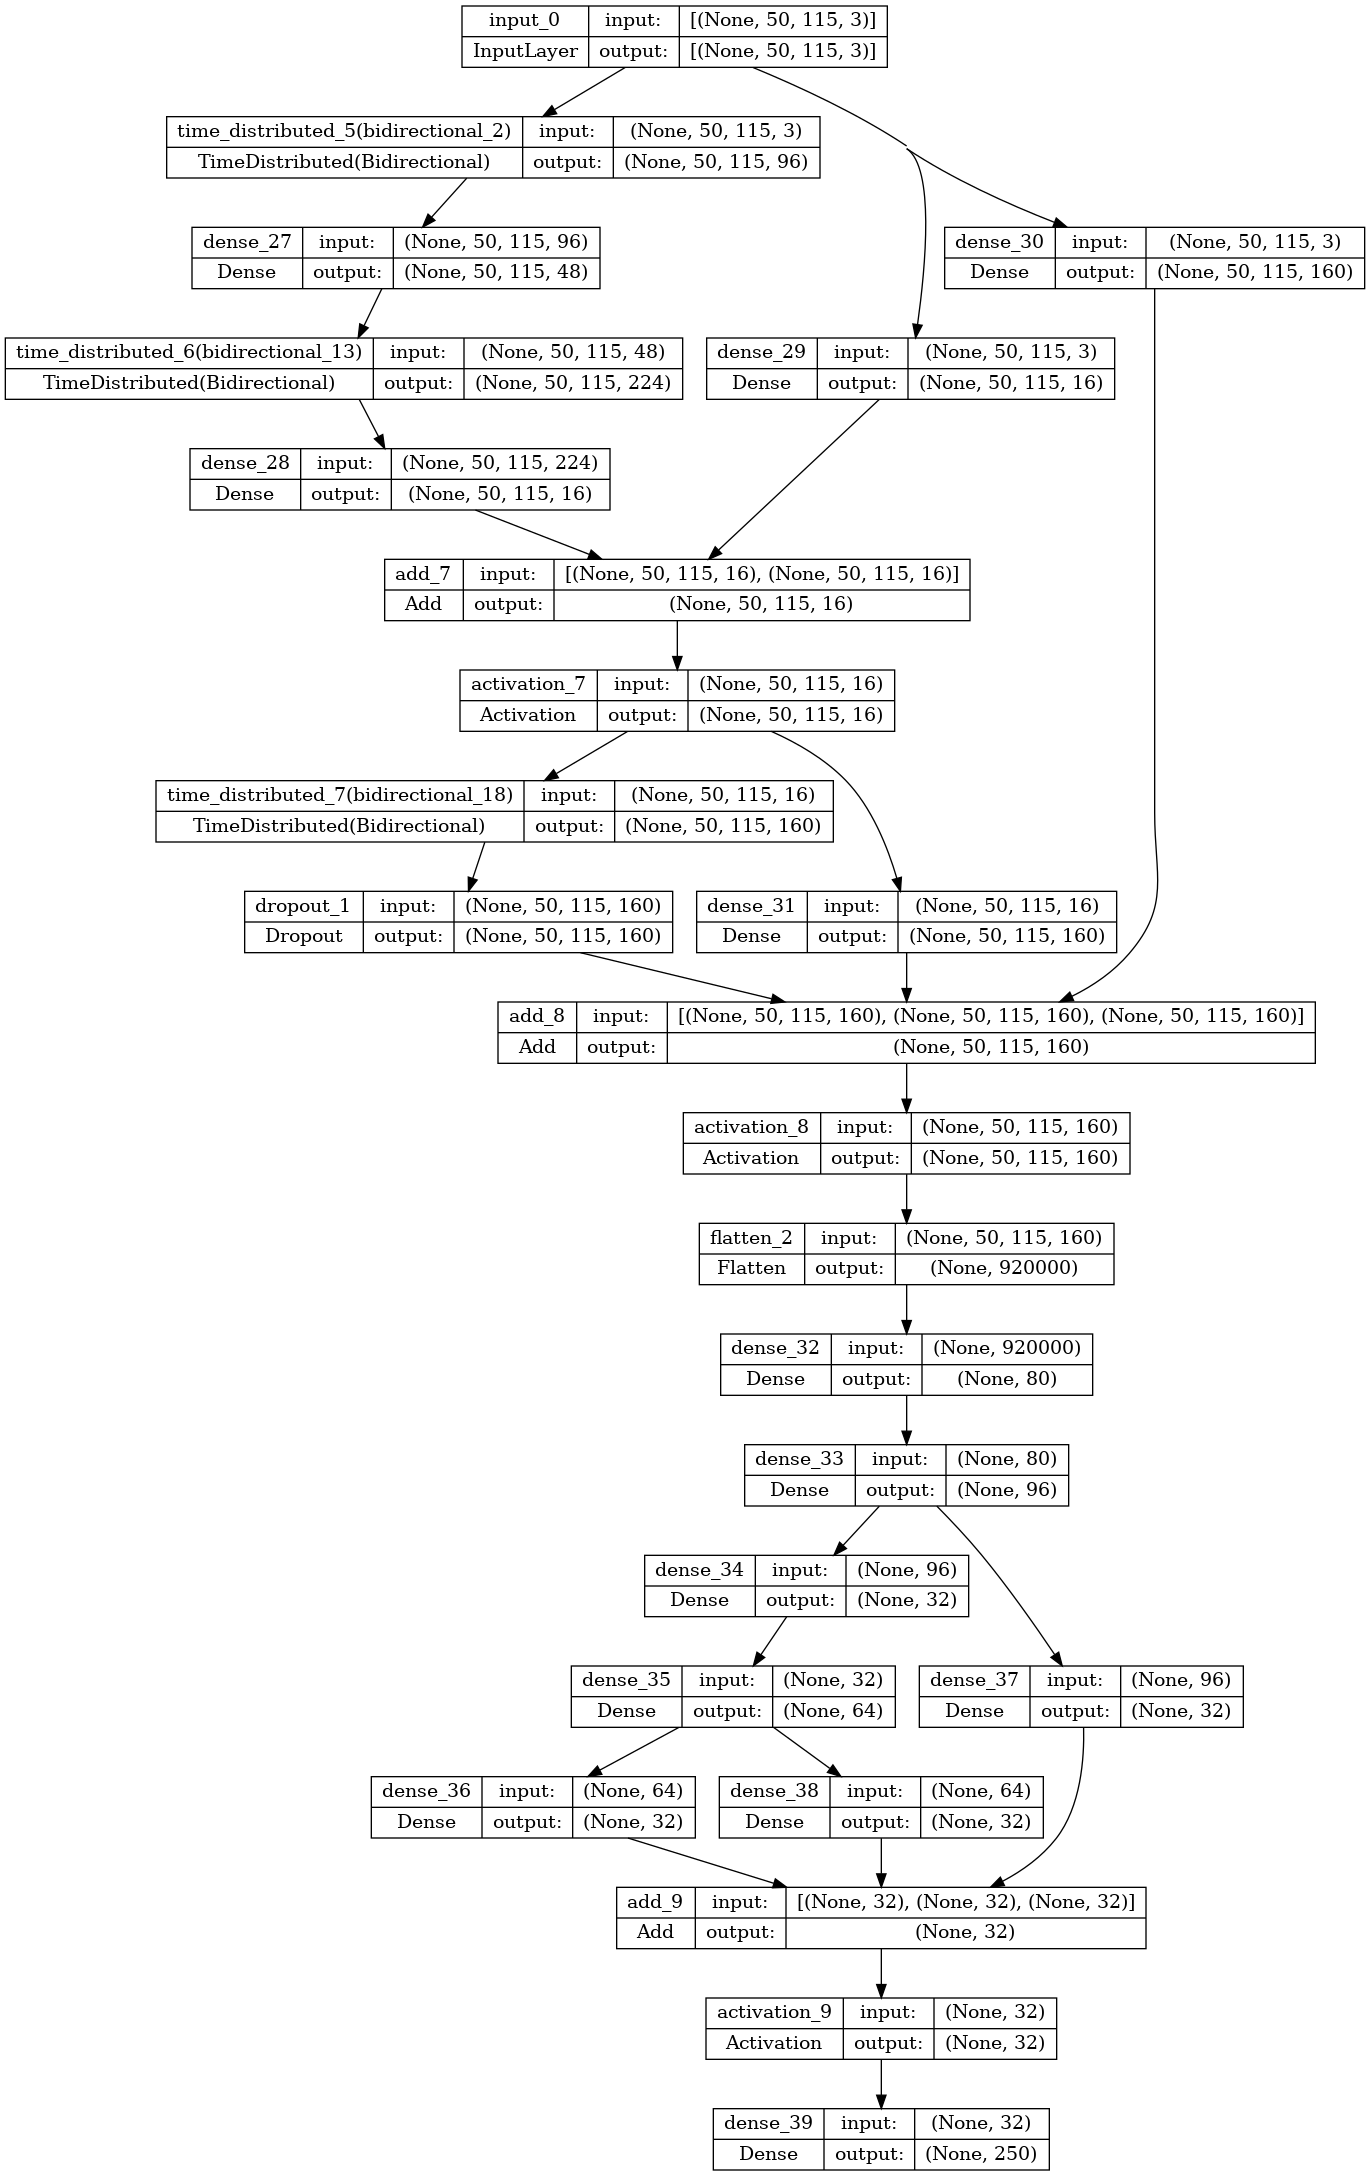

In [19]:
arch_best = [3, 21, 0, 7, 13, 1, 0, 5, 6, 1, 0, 1, 19, 21, 8, 16, 6, 0, 1, 0, 1, 0]
best = space.sample(arch_best)
plot_model(best, show_shapes=True)

---

# ---------------------- 

---

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
DATA_LENGTH = 94477
BATCH_SIZE = 64 
GLOBAL_BATCH_SIZE = BATCH_SIZE
AUTO = tf.data.AUTOTUNE


##### Read TFRecord file
def _parse_tfr_element(element):
    parse_dic = {
    'b_feature': tf.io.FixedLenFeature([], tf.string), # Note that it is tf.string, not tf.float32
    'b_label': tf.io.FixedLenFeature([], tf.string),
    }
    example_message = tf.io.parse_single_example(element, parse_dic)

    b_feature = example_message['b_feature'] # get byte string
    b_label = example_message['b_label']
    
    feature = tf.io.parse_tensor(b_feature, out_type=tf.float32) # restore 2D array from byte string
    label = tf.io.parse_tensor(b_label, out_type=tf.int32)
    return (feature, label)

filenames = [f'kaggle/input/tfrecords-sequences-for-asl/data{i}.tfrecords' for i in range(20)]
train_dataset = tf.data.TFRecordDataset(filenames) 
train_dataset = train_dataset.map(_parse_tfr_element, num_parallel_calls=AUTO).prefetch(AUTO)

In [ ]:
def load_data_out():
    feature = []
    label = []
    for i,j in enumerate(train_dataset):
        feature.append(j[0])
        label.append(j[1])
    return tf.stack(feature,0), tf.stack(label,0)

X,y = load_data_out()

In [3]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [18]:
with strategy.scope():
    arch_best = [3, 21, 0, 7, 13, 1, 0, 5, 6, 1, 0, 1, 19, 21, 8, 16, 6, 0, 1, 0, 1, 0]
    shapes = dict(input_shape=[(50,115,3)], output_shape=(250,))
    space = LSTMLP_Factory(**shapes,num_layers=3).build()
    best = space.sample(arch_best)
    best.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2), 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])
best.fit(
    X,y,
    batch_size=32,
    epochs=100,
    verbose=1,
    validation_split=0.1,
  #  workers=4,
   # use_multiprocessing=True,
)

#best.evaluate(train_dataset)

NameError: name 'X' is not defined